In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Funções especializadas de statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import ARIMA, SARIMAX

from scipy.stats import norm


In [32]:
# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [6]:
# Carregando e ajustando os dados
data = pd.read_csv("../data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")["volume"]

print(data_series.head())

week
2022-10-31    0.33
2022-11-07    0.47
2022-11-14    0.32
2022-11-21    1.69
2022-11-28    1.23
Name: volume, dtype: float64


In [70]:
ts_volume = data['volume']

eighty_percent_data = int((len(ts_volume)*0.8))
# Divisão cronológica dos dados
train = ts_volume.iloc[:-eighty_percent_data]
test = ts_volume.iloc[-eighty_percent_data:]

# Métodos Baselines

## Média
Começamos com o método mais ingênuo, o qual é estimar todos os outroso como a média do treino. 

In [71]:
predictions = {}

mean_forecast = np.mean(train)
predictions['Média'] = pd.Series(mean_forecast, index=test.index)

## Random Walk without Drift
O próximo método que temos é o Random Walk without drift, o qual consiste em simplesmente pegar o último valor e prever todos os próximos valores como ele.

In [72]:
random_naive_pred = train.iloc[-1]
predictions['Ingênuo'] = pd.Series(random_naive_pred, index=test.index)

## Random Walk with Drift
O método tende a prever o úlitmo valor, mas adiciona a tendência dos dados. Como por exemplo, se os dados tendem a ter uma queda no treino, o modelo vai decrescer essa taxa para as próximas previsões. Caso haja um crescimento o modelo acresce a taxa. 

In [37]:
T = len(train)
drift_value = (train.iloc[-1] - train.iloc[0]) / (T - 1)
h_steps = np.arange(1, len(test) + 1)
drift_forecast = train.iloc[-1] + h_steps * drift_value
predictions['Desvio (Drift)'] = pd.Series(drift_forecast, index=test.index)

## Método Ingênuo Sazonal
No método ingênuo sazonal, o que fazemos é assumir que há sazonalidade nos dados e apenas assumir que o próximo valor será o mésmo do último período que ele apareceu. como o modelo está em semanas, umas sazonalidade de 52 faz sentido. Podemos utilizar a classe sarimax do statsmodel que nós da essa previsão sem maiores esforços

In [38]:
m = 52
model_snaive = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 1, 0, m))
fit_snaive = model_snaive.fit(disp=False)
predictions['Ingênuo Sazonal'] = fit_snaive.forecast(steps=len(test))

## Visualização dos modelos

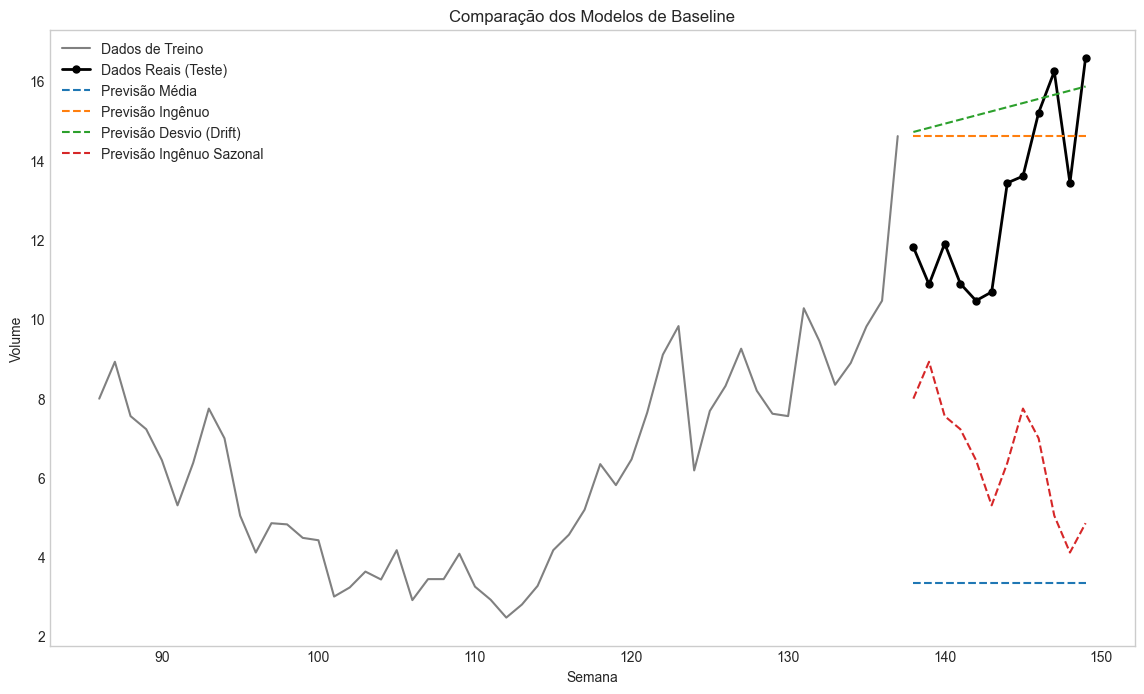

In [ ]:
# 4. Avaliação e Visualização (Inalterado)
plt.figure(figsize=(14, 8))
plt.plot(train.iloc[-52:], label='Dados de Treino', color='gray')
plt.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')

plt.title('Comparação dos Modelos de Baseline')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)
plt.show()

## Avaliando a previsão distribucional
Temos várias métricas para avaliar a previsão distribucional, tais quais:
winkler score, quantila score e Continuos ranked probability score (CRPS) (escrever mais sobre)

In [ ]:
# Função para o Winkler Score
def winkler_score(y_true, lower, upper, alpha):
    score = np.where(
        y_true < lower,
        (upper - lower) + (2 / alpha) * (lower - y_true),
        np.where(
            y_true > upper,
            (upper - lower) + (2 / alpha) * (y_true - upper),
            (upper - lower)
        )
    )
    return np.mean(score)

# Função para o Erro de Quantil
def quantile_score(y_true, quantile_forecast, p):
    error = y_true - quantile_forecast
    return np.mean(np.where(error >= 0, p * error, (p - 1) * error))

# Função para o CRPS de uma distribuição Normal
def crps_gaussian(y_true, mu, sigma):
    z = (y_true - mu) / sigma
    crps = sigma * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))
    return np.mean(crps)

## Análise comparativa dos modelos

In [ ]:
alpha = 0.05
intervals = {}
residuals_std = {}

# Desvio Padrões de cada modelo
residuals_std['Média'] = (train - train.mean()).std()
residuals_std['Ingênuo'] = (train - train.shift(1)).std()
residuals_std['Desvio (Drift)'] = (train - (train.shift(1) + drift_value)).std()
residuals_std['Ingênuo Sazonal'] = fit_snaive.resid.std()

# Calculando os intervalos
for name in predictions.keys():
    sigma = residuals_std[name]
    if name == 'Média':
        sigma_h = sigma * np.sqrt(1 + 1/T)
    elif name == 'Ingênuo':
        sigma_h = sigma * np.sqrt(h_steps)
    elif name == 'Desvio (Drift)':
        sigma_h = sigma * np.sqrt(h_steps * (h_steps + 1) / (T - 1))
    elif name == 'Ingênuo Sazonal':
        K = np.floor((h_steps - 1) / m)
        sigma_h = sigma * np.sqrt(K + 1)
    
    intervals[name] = {
        'lower': predictions[name] - 1.96 * sigma_h,
        'upper': predictions[name] + 1.96 * sigma_h
    }



## Métricas
Com as métricas já calculadas, podemos mostrar a tabela com cada uma das métricas.

3.4286046511627917


In [ ]:
results_list = []

# Denominador para o MASE
scale = np.mean(np.abs(train.diff(m).dropna()))
# Níveis de quantis para avaliar no CRPS
quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

# Loop principal sobre cada modelo
for name, forecast in predictions.items():
    # Pega os valores pré-calculados para o modelo atual
    interval = intervals[name]
    sigma = residuals_std[name]
    
    # Calcula as métricas de previsão pontual
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    mase = mae / scale
    
    # Calcula o Winkler Score para o intervalo
    winkler = winkler_score(test, interval['lower'], interval['upper'], alpha)
    
    # Calcula o sigma_h (desvio padrão no horizonte de previsão) para o CRPS e o Erro de Quantil
    if name == 'Média':
        sigma_h = sigma * np.sqrt(1 + 1/T)
    elif name == 'Ingênuo':
        sigma_h = sigma * np.sqrt(h_steps)
    elif name == 'Desvio (Drift)':
        sigma_h = sigma * np.sqrt(h_steps * (h_steps + 1) / (T - 1))
    elif name == 'Ingênuo Sazonal':
        K = np.floor((h_steps - 1) / m)
        sigma_h = sigma * np.sqrt(K + 1)
        
    # Calcula o CRPS (usando o sigma_h correto)
    crps = crps_gaussian(test, forecast, sigma_h)

    # Calcula o Erro de Quantil Médio
    avg_quantile_loss = []
    for p in quantiles_to_check:
        quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
        avg_quantile_loss.append(quantile_score(test, quantile_forecast, p))
    
    # Armazena TODOS os resultados para o modelo atual
    results_list.append({
        'Modelo': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape * 100,
        'MASE': mase,
        'Winkler Score': winkler,
        'Avg Quantile Score': np.mean(avg_quantile_loss),
        'CRPS': crps
    })

results_df = pd.DataFrame(results_list).set_index('Modelo')
print("\n--- Tabela Comparativa de Métricas (Versão Final Completa) ---")
results_df.round(4)


--- Tabela Comparativa de Métricas (Versão Final Completa) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Média,9.5715,9.7967,73.3997,2.7917,145.2554,3.9164,7.7809
Ingênuo,2.3850,2.6834,20.1978,0.6956,19.4807,0.8866,1.7674
Desvio (Drift),2.5820,2.9764,22.2517,0.7531,75.6148,1.1783,2.3545
Ingênuo Sazonal,6.3817,7.0570,47.3454,1.8613,107.2481,2.6225,5.2320


Podemos ver que o método ingênuo (random walk) foi o que melhor se saiu comparando as métricas de avaliação. Conseguimos todas as métricas menores que as outras.

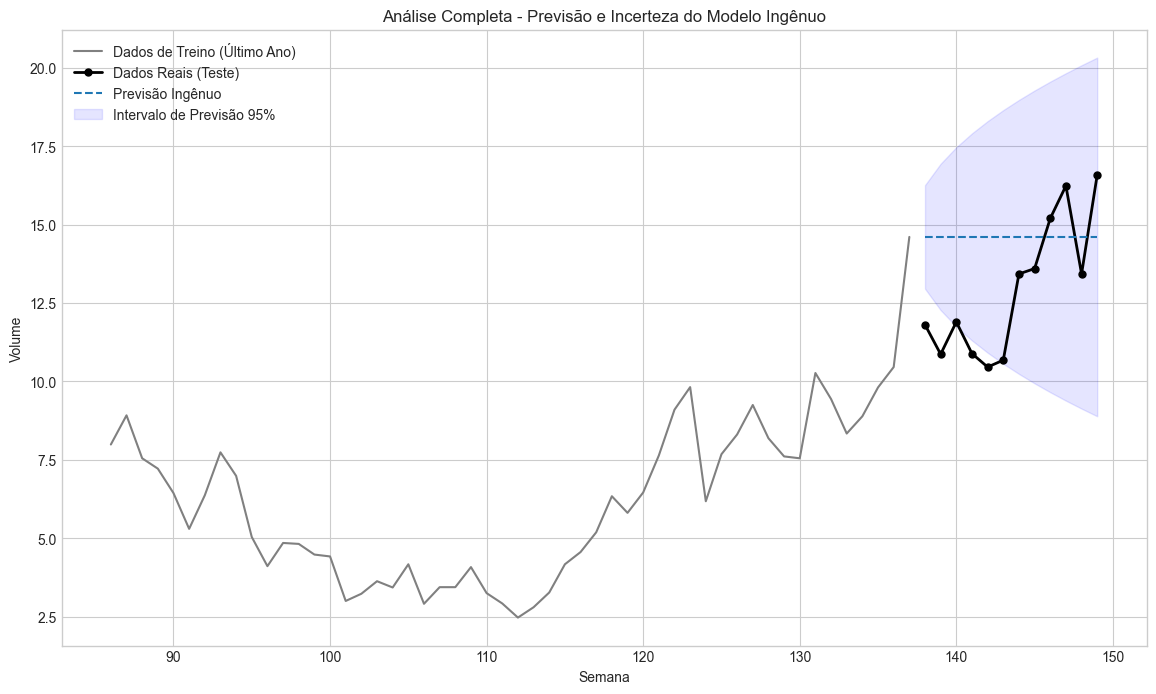

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(train.iloc[-52:], label='Dados de Treino (Último Ano)', color='gray')
plt.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)

# Escolha o modelo com melhor performance geral para destacar no gráfico
best_model_name = results_df['Winkler Score'].idxmin() 
forecast_to_plot = predictions[best_model_name]
interval_to_plot = intervals[best_model_name]

plt.plot(forecast_to_plot, label=f'Previsão {best_model_name}', linestyle='--')
plt.fill_between(
    interval_to_plot['lower'].index,
    interval_to_plot['lower'],
    interval_to_plot['upper'],
    color='blue',
    alpha=0.1,
    label='Intervalo de Previsão 95%'
)

plt.title(f'Análise Completa - Previsão e Incerteza do Modelo {best_model_name}')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

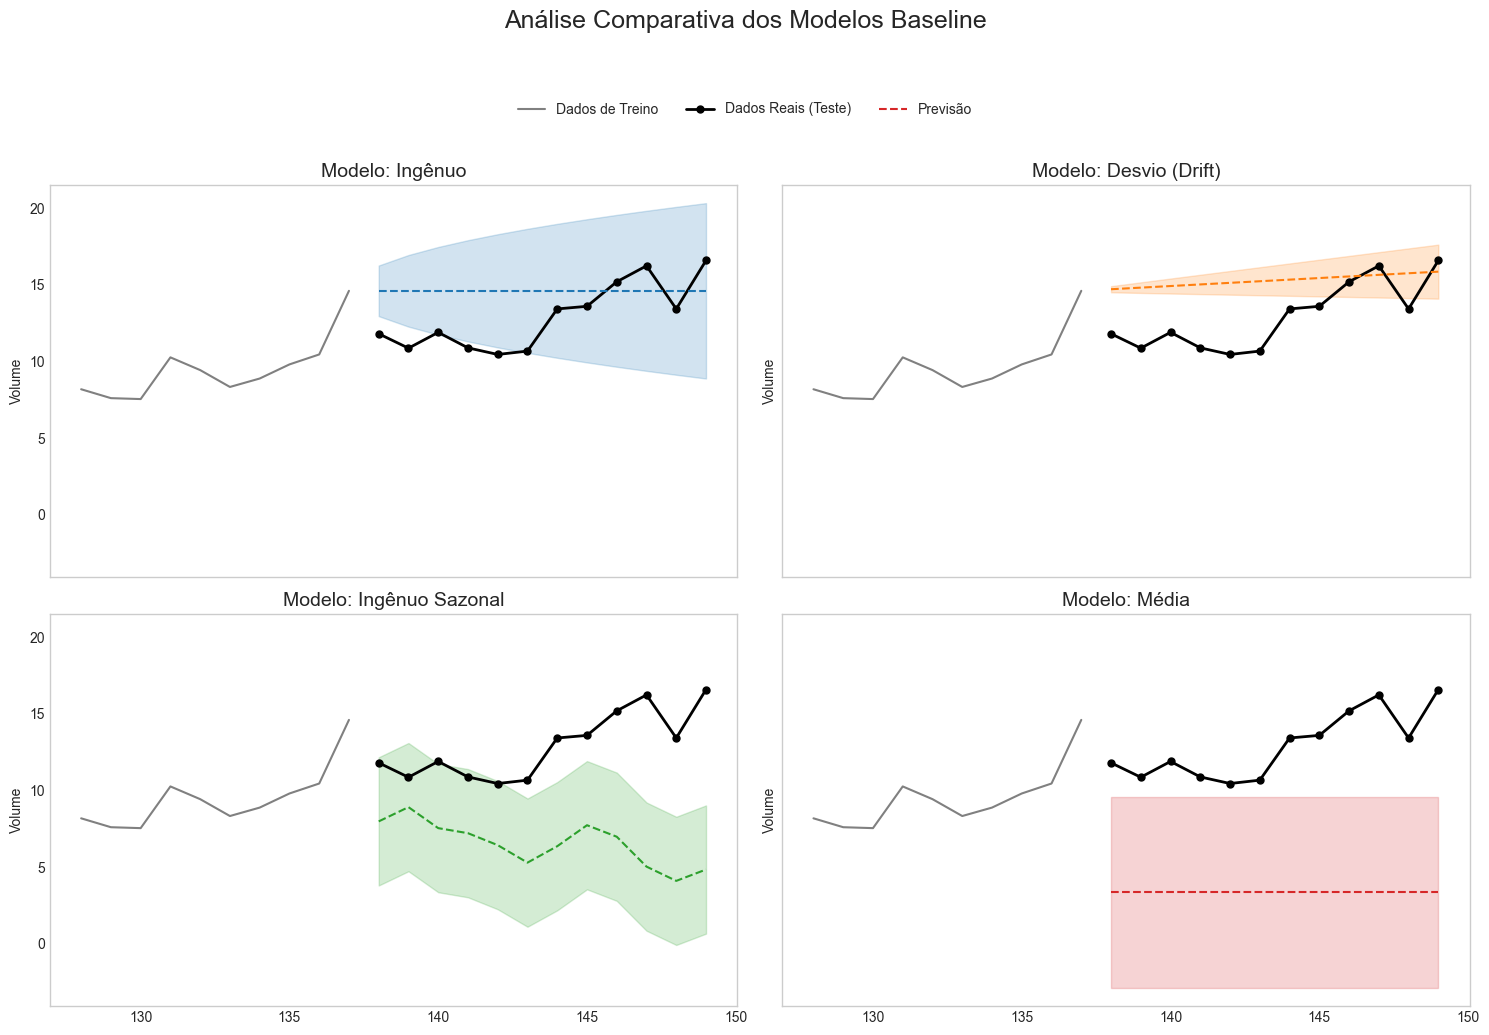

In [ ]:
n_models = len(predictions)
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Define a paleta de cores
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Azul, Laranja, Verde, Vermelho

# << ALTERAÇÃO AQUI: Define a ordem de plotagem desejada
plot_order = ['Ingênuo', 'Desvio (Drift)', 'Ingênuo Sazonal', 'Média']

for i, name in enumerate(plot_order):
    ax = axes.flatten()[i] 
    color = colors[i % len(colors)]
    
    # Plota os dados base
    ax.plot(train.iloc[-10:], label='Dados de Treino', color='gray')
    ax.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)
    
    # Previsão e intervalo com a cor específica
    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]
    ax.plot(forecast_to_plot, label=f'Previsão', linestyle='--', color=color)
    
    # Plota o intervalo de previsão sombreado
    ax.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        alpha=0.2,
        color=color
    )
    
    # Configurações do gráfico individual
    ax.set_title(f'Modelo: {name}', fontsize=14)
    ax.set_ylabel('Volume')
    ax.grid(False)

# Configurações gerais do painel de gráficos
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
fig.suptitle('Análise Comparativa dos Modelos Baseline', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

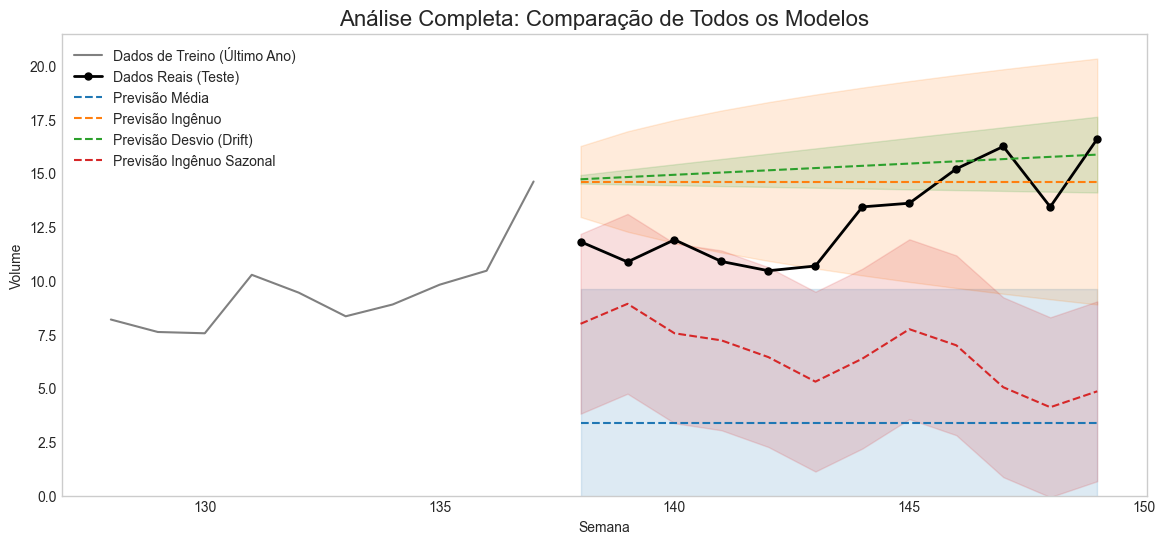

In [ ]:
# --- 5. Visualização Completa em um Único Gráfico ---

plt.figure(figsize=(14, 6))

# Plota os dados de treino e teste como base
plt.plot(train.iloc[-10:], label='Dados de Treino (Último Ano)', color='gray')
plt.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)

# Define uma paleta de cores para os modelos
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Azul, Laranja, Verde, Vermelho

# Loop para plotar cada modelo com uma cor diferente
for i, name in enumerate(predictions.keys()):
    color = colors[i % len(colors)]
    
    # Recupera a previsão e o intervalo para o modelo atual
    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]
    
    # Plota a linha de previsão pontual
    plt.plot(forecast_to_plot, label=f'Previsão {name}', color=color, linestyle='--')
    
    # Plota a área do intervalo de previsão com transparência
    # O intervalo não tem um label próprio para manter a legenda limpa;
    # a cor o associa à sua linha de previsão.
    plt.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        color=color,
        alpha=0.15 
    )

# Configurações finais do gráfico
plt.title('Análise Completa: Comparação de Todos os Modelos', fontsize=16)
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)
plt.ylim(bottom=0)
plt.show()